In [1]:
#import everything needed here for all once!

import os
import csv
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout
from keras.layers.convolutional import Convolution2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# load training data and split into training and validation
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

    train_samples, validation_samples = train_test_split(samples, test_size=0.2)
    #print (samples)

In [3]:
#Image brightness

def img_bright(img):
    rand = np.random.uniform(0.3, 1.2)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * rand
    img2 = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img2

In [4]:
#Generator to pull on-the-fly

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for camera in range(3):
                    name = './data/IMG/'+batch_sample[camera].split('/')[-1]
                    #print (name)
                    
                    image = cv2.imread(name)
                    
                    #image = img_bright(image)
                    
                    #cropping 
                    img = image[60:140,:,:]
                    
                    #resize
                    image = cv2.resize(img,(64, 64), interpolation=cv2.INTER_AREA)
                    
                    #Get angle
                    angle = float(batch_sample[3])
                
                    #append image and it's flip
                    images.append(image)
                    images.append(cv2.flip(image, 1))
                
                #Use input from 3 cameras with correction as 0.2.
                #Use it's flip also
                angles.append(angle)
                angles.append(angle*-1.0)
                angles.append(angle + 0.2)
                angles.append((angle + 0.2)*-1.0)
                angles.append((angle - 0.2))
                angles.append((angle - 0.2)*-1.0)
                                

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [5]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [6]:
ch, row, col = 64, 64, 3 # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: x/255.0 - 0.5,
        input_shape=(ch, row, col),
        output_shape=(ch, row, col)))
#model.add(Cropping2D(cropping=((50, 20),(0,0))))

#My model with reference to nvidia model.
model.add(Convolution2D(24,5,5, subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))

model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Dropout(0.50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 30, 30, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 13, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 5, 48)      43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [7]:
#Loss as MSE and optimizer as adam

model.compile(loss='mse', optimizer='adam')
data = model.fit_generator(train_generator, samples_per_epoch=len(train_samples*6), validation_data=validation_generator, nb_val_samples=len(validation_samples*6), nb_epoch=5, verbose = 1)

model.save('model.h5')

print ("Model saved.")

Epoch 1/5
38568/38568 [==============================] - 191s - loss: 0.0216 - val_loss: 0.0168
Epoch 2/5
38568/38568 [==============================] - 190s - loss: 0.0168 - val_loss: 0.0155
Epoch 3/5
38568/38568 [==============================] - 192s - loss: 0.0151 - val_loss: 0.0144
Epoch 4/5
38568/38568 [==============================] - 195s - loss: 0.0138 - val_loss: 0.0136
Epoch 5/5
38568/38568 [==============================] - 211s - loss: 0.0130 - val_loss: 0.0134
Model saved.


In [9]:
print(data.history.keys())

dict_keys(['loss', 'val_loss'])


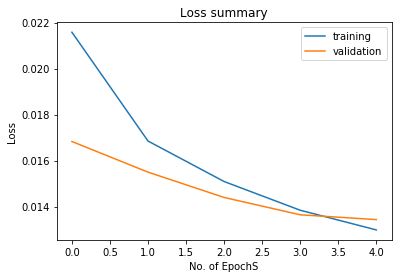

In [8]:
#Plot loss and validation loss

plt.plot(data.history['loss'])
plt.plot(data.history['val_loss'])
plt.title('Loss summary')
plt.ylabel('Loss')
plt.xlabel('No. of EpochS')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()